# 군집 분석 - 고객 세그멘테이션

- [UCI Machine Learning Repository 데이터 이용](http://archive.ics.uci.edu/ml/datasets/online+retail)

- 데이터 개요 : 영국 무점포 온라인 소매상들에게 접수된 제품 주문 데이터 세트 (2010년 12월 1일 ~ 2011년 12월 9일)

- feature 설명

|Features|설명|
|-|-|
|InvoiceNo|주문번호. 'C'로 시작하는 것은 취소 주문|
|StockCode|제품 코드|
|Description|제품 설명|
|Quantity|주문 제품 건수|
|InvoiceDate|주문 일자|
|UnitPrice|제품 단가|
|CustomerID|고객 번호|
|Country|국가명(주문 고객의 국적)|

### 1. 데이터 세트 로딩과 데이터 클렌징

In [1]:
# 패키지 불러오기
import pandas as pd
import datetime
import math
import numpy as np
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline

In [2]:
# 데이터 로드
# Data Load
# 연산 시간이 너무 오래 걸려 csv파일로 변환 후 대체
csvFile = 'C:/Users/chunc/Desktop/취업캠프/python/python/머신러닝과 딥러닝/고객 세그멘테이션_Online_Retail/Online_Retail.csv'
retail_df = pd.read_csv(csvFile)
retail_df.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom


In [3]:
# 개괄적인 데이터 정보 확인
retail_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 541909 entries, 0 to 541908
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   InvoiceNo    541909 non-null  object 
 1   StockCode    541909 non-null  object 
 2   Description  540455 non-null  object 
 3   Quantity     541909 non-null  int64  
 4   InvoiceDate  541909 non-null  object 
 5   UnitPrice    541909 non-null  float64
 6   CustomerID   406829 non-null  float64
 7   Country      541909 non-null  object 
dtypes: float64(2), int64(1), object(5)
memory usage: 33.1+ MB


In [4]:
# Quantity가 0보다 적은 오류 데이터 존재 
# retail_df DataFrame의 Quantity 컬럼에 대한 인덱싱 변수 mask_1 선언
mask_1 = retail_df['Quantity'] < 0
retail_df[mask_1]

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
141,C536379,D,Discount,-1,2010-12-01 09:41:00,27.50,14527.0,United Kingdom
154,C536383,35004C,SET OF 3 COLOURED FLYING DUCKS,-1,2010-12-01 09:49:00,4.65,15311.0,United Kingdom
235,C536391,22556,PLASTERS IN TIN CIRCUS PARADE,-12,2010-12-01 10:24:00,1.65,17548.0,United Kingdom
236,C536391,21984,PACK OF 12 PINK PAISLEY TISSUES,-24,2010-12-01 10:24:00,0.29,17548.0,United Kingdom
237,C536391,21983,PACK OF 12 BLUE PAISLEY TISSUES,-24,2010-12-01 10:24:00,0.29,17548.0,United Kingdom
...,...,...,...,...,...,...,...,...
540449,C581490,23144,ZINC T-LIGHT HOLDER STARS SMALL,-11,2011-12-09 09:57:00,0.83,14397.0,United Kingdom
541541,C581499,M,Manual,-1,2011-12-09 10:28:00,224.69,15498.0,United Kingdom
541715,C581568,21258,VICTORIAN SEWING BOX LARGE,-5,2011-12-09 11:57:00,10.95,15311.0,United Kingdom
541716,C581569,84978,HANGING HEART JAR T-LIGHT HOLDER,-1,2011-12-09 11:58:00,1.25,17315.0,United Kingdom


In [5]:
# UnitPrice가 0보다 작은 오류 데이터 존재
# retail_df DataFrame의 UnitPrice 컬럼에 대한 인덱싱 변수 mask_2 선언
mask_2 = retail_df['UnitPrice'] < 0
retail_df[mask_2]

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
299983,A563186,B,Adjust bad debt,1,2011-08-12 14:51:00,-11062.06,NaN,United Kingdom
299984,A563187,B,Adjust bad debt,1,2011-08-12 14:52:00,-11062.06,NaN,United Kingdom


In [6]:
# retail_df에서 Quantity가 0보다 큰 데이터만 남기고 제거
retail_df = retail_df[retail_df['Quantity'] > 0]

# retail_df에서 UnitPrice가 0보다 큰 데이터만 남기고 제거
retail_df = retail_df[retail_df['UnitPrice'] > 0]

# 목표는 고객 segmentation이므로 CustomerID가 없는 고객 정보는 사용 불가능 -> 데이터 제거
retail_df = retail_df[retail_df['CustomerID'].notnull()]

# 오류/null값이 제거된 retail_df 형태 확인
print(retail_df.shape)

# null값 확인
retail_df.isnull().sum()

(397884, 8)


InvoiceNo      0
StockCode      0
Description    0
Quantity       0
InvoiceDate    0
UnitPrice      0
CustomerID     0
Country        0
dtype: int64

* null값들이 모두 제거됨을 알 수 있다.

In [7]:
# 주문 고객의 국적 확인
# 영국 이외에도 다른 영연방(EIRE;아일랜드), EU(독일, 프랑스, 스페인)국가 존재
retail_df['Country'].unique()

array(['United Kingdom', 'France', 'Australia', 'Netherlands', 'Germany',
       'Norway', 'EIRE', 'Switzerland', 'Spain', 'Poland', 'Portugal',
       'Italy', 'Belgium', 'Lithuania', 'Japan', 'Iceland',
       'Channel Islands', 'Denmark', 'Cyprus', 'Sweden', 'Finland',
       'Austria', 'Greece', 'Singapore', 'Lebanon',
       'United Arab Emirates', 'Israel', 'Saudi Arabia', 'Czech Republic',
       'Canada', 'Unspecified', 'Brazil', 'USA', 'European Community',
       'Bahrain', 'Malta', 'RSA'], dtype=object)

In [8]:
retail_df['Country'].value_counts()[:10]

United Kingdom    354321
Germany             9040
France              8341
EIRE                7236
Spain               2484
Netherlands         2359
Belgium             2031
Switzerland         1841
Portugal            1462
Australia           1182
Name: Country, dtype: int64

In [9]:
# 영국 고객이 주 분석 대상이므로 Country컬럼이 'United Kingdom'인 데이터만 인덱싱하여 추출
retail_df = retail_df[retail_df['Country'] == 'United Kingdom']
print(retail_df.shape)

(354321, 8)


In [10]:
retail_df.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom


### 2. RFM기반 데이터 가공

* 고객 세그멘테이션에서 전통적으로 많이 활용되는 RFM을 기반으로 군집화 수행
    - Recency: 가장 최근 상품 구입일에서 오늘까지의 계산
    - Frequency: 상품 구매 횟수
    - Monetary: 총 구매 금액

In [11]:
# 총 구매 금액을 도출하기 위하여 Quantity 컬럼에 UnitPrice를 곱해 sale_amount 컬럼 생성 
retail_df['sale_amount'] = retail_df['Quantity'] * retail_df['UnitPrice']

# 기존 float인 CustomerID를 식별이 편리하도록 int로 변환
retail_df['CustomerID'] = retail_df['CustomerID'].astype(int)

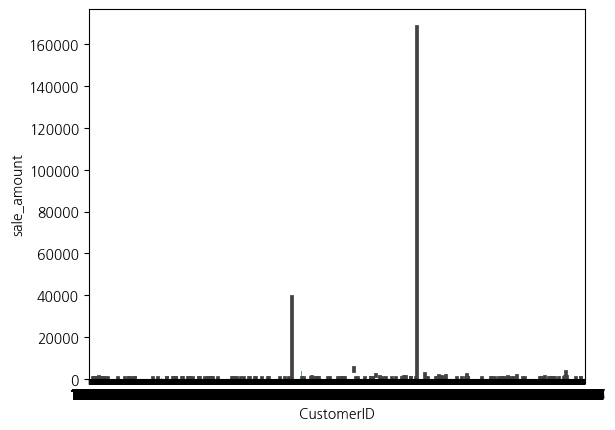

In [12]:
# 시각화를 통한 확인
import matplotlib.pyplot as plt
import seaborn as sns

# barplot을 이용하여 x축 CustomerID, y축 sale_amount인 그래프 확인
sns.barplot(data = retail_df, x = 'CustomerID', y = 'sale_amount')
plt.show()

* 위의 그래프를 보면 판매액이 특정 고객에게 몰리는 경향을 볼 수 있는데, 그 이유는 개인 고객 판매와 도매 판매가 함께 포함되어 있기 때문이다.

In [13]:
# CustomerID 컬럼의 unique값별 count를 통해 복수 주문 고객 중 상위 5명 확인
# retail_df['CustomerID'].value_counts().head()
print(retail_df['CustomerID'].value_counts().head(5))

17841    7847
14096    5111
12748    4595
14606    2700
15311    2379
Name: CustomerID, dtype: int64


In [14]:
# 여러번 주문한 고객들이 존재하므로 CustomerID를 기준으로 groupby
# 각 CustoerID별로 집계된 sale_amount총합 중 상위 5개 출력
print(retail_df.groupby('CustomerID')['sale_amount'].sum().sort_values(ascending=False)[:5])
# print(retail_df.groupby('CustomerID')['sale_amount'].sum().sort_values(ascending = False).head(5))

CustomerID
18102    259657.30
17450    194550.79
16446    168472.50
17511     91062.38
16029     81024.84
Name: sale_amount, dtype: float64


In [15]:
# Recency: 가장 최근 상품 구입일에서 오늘까지의 기간, Frequency: 상품 구매 횟수, Monetary value: 총 구매 금액 산출을 위해 agg() 이용

# - Recency: InvoiceDate 컬럼의 max() 에서 데이터 가공 (max(최대값)=가장 최근 상품 구입일)
# - Frequency: InvoiceNo 컬럼의 count() 사용
# - Monetary value: sale_amount 컬럼의 sum() 사용
# agg() 사용을 위한 parameter 정의
aggregations = {'InvoiceDate': 'max', 'InvoiceNo': 'count', 'sale_amount': 'sum'}

# cust_df변수를 선언하여 집계함수 결과 저장
cust_df = retail_df.groupby('CustomerID').agg(aggregations)

# 집계함수 결과 컬럼값을 Recency, Frequency, Monetary로 변경
cust_df = cust_df.rename(columns = {'InvoiceDate': 'Recency', 'InvoiceNo': 'Frequency', 'sale_amount': 'Monetary'})

# CustomerID를 다시 컬럼으로 사용, 인덱스 초기화
cust_df = cust_df.reset_index()
cust_df.head(10)

,CustomerID,Recency,Frequency,Monetary
0,12346,2011-01-18 10:01:00,1,77183.60
1,12747,2011-12-07 14:34:00,103,4196.01
2,12748,2011-12-09 12:20:00,4595,33719.73
3,12749,2011-12-06 09:56:00,199,4090.88
4,12820,2011-12-06 15:12:00,59,942.34
5,12821,2011-05-09 15:51:00,6,92.72
6,12822,2011-09-30 10:04:00,46,948.88
7,12823,2011-09-26 07:35:00,5,1759.50
8,12824,2011-10-11 12:49:00,25,397.12
9,12826,2011-12-07 10:25:00,91,1474.72


In [16]:
cust_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3920 entries, 0 to 3919
Data columns (total 4 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   CustomerID  3920 non-null   int64  
 1   Recency     3920 non-null   object 
 2   Frequency   3920 non-null   int64  
 3   Monetary    3920 non-null   float64
dtypes: float64(1), int64(2), object(1)
memory usage: 122.6+ KB


In [17]:
cust_df['Recency']

0       2011-01-18 10:01:00
1       2011-12-07 14:34:00
2       2011-12-09 12:20:00
3       2011-12-06 09:56:00
4       2011-12-06 15:12:00
               ...         
3915    2011-03-07 09:52:00
3916    2011-06-12 10:53:00
3917    2011-12-02 11:43:00
3918    2011-12-06 12:02:00
3919    2011-10-28 09:29:00
Name: Recency, Length: 3920, dtype: object

In [18]:
# python의 datetime 모듈을 불러와 Recency 컬럼 가공 
import datetime as dt

# 현재 Recency 컬럼은 문자열이므로 datetime type으로 변환
cust_df['Recency'] = pd.to_datetime(cust_df['Recency'])

In [19]:
# Recency 컬럼을 분석 현재일 - 가장 최근 구매일로 변환
# 현재일은 2011년 12월 10일로 설정
cust_df['Recency'] = dt.datetime(2011, 12, 10) - cust_df['Recency']

# 000 days 00:00:00 형태의 datetime에서 days 부분만 추출
# 이때 0 days 11:40:00같은 경우는 0days가 되므로 모든 날짜에 +1일을 수행
cust_df['Recency'] = cust_df['Recency'].apply(lambda x: x.days + 1)

# 수정된 cust_df의 형태 출력
print('shape of cust_df', cust_df.shape)
cust_df.head()

shape of cust_df (3920, 4)


,CustomerID,Recency,Frequency,Monetary
0,12346,326,1,77183.60
1,12747,3,103,4196.01
2,12748,1,4595,33719.73
3,12749,4,199,4090.88
4,12820,4,59,942.34


### 3. RFM기반 고객 세그멘테이션

* 앞서 언급한 것처럼 본 데이터세트는 개인 구매와 도매 구입이 혼재하여 특정 고객에게 거래가 집중되는 경향이 존재한다.
* 비교를 위해서 먼저 로그변환을 사용하지 않고 k평균 군집을 실시해본다.

(array([3.887e+03, 1.900e+01, 9.000e+00, 2.000e+00, 0.000e+00, 0.000e+00,
        1.000e+00, 1.000e+00, 0.000e+00, 1.000e+00]),
 array([3.75000000e+00, 2.59691050e+04, 5.19344600e+04, 7.78998150e+04,
        1.03865170e+05, 1.29830525e+05, 1.55795880e+05, 1.81761235e+05,
        2.07726590e+05, 2.33691945e+05, 2.59657300e+05]),
 <BarContainer object of 10 artists>)

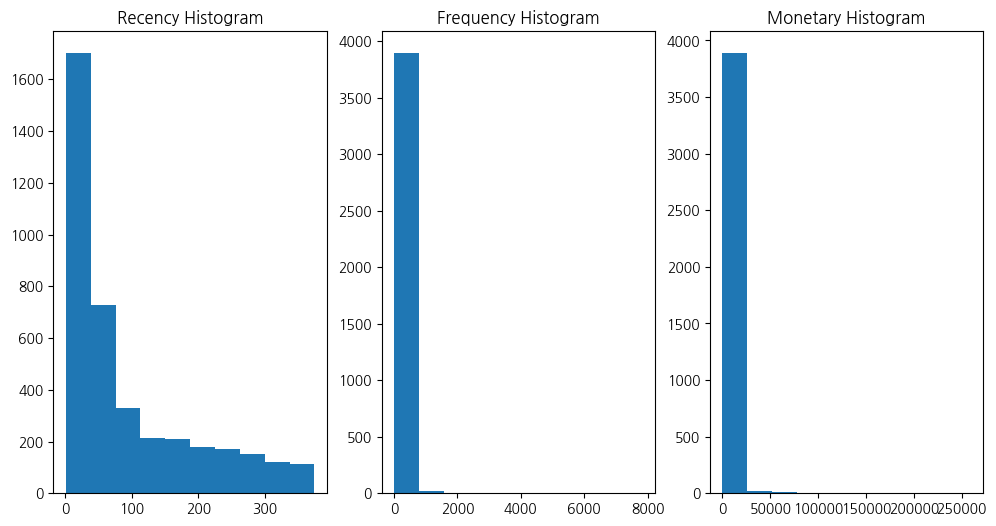

In [20]:
# 그래프를 통해 데이터의 왜곡 정도 확인
# matplotlib의 hist()를 사용하여 Recency, Frequency, Monetary 컬럼의 분포 확인
# subplot 3개(ax1, ax2, ax3)가 포함된 fig 객체 선언
fig, (ax1, ax2, ax3) = plt.subplots(figsize = (12, 6), ncols = 3)

# 첫 번째 subplot ax1의 제목을 'Recency Histogram'으로 설정
ax1.set_title('Recency Histogram')

# 첫 번째 히스토그램 출력
ax1.hist(cust_df['Recency'])

# 두 번째 subplot ax1의 제목을 'Frequency Histogram'으로 설정
ax2.set_title('Frequency Histogram')

# 두 번째 히스토그램 출력
ax2.hist(cust_df['Frequency'])

# 세 번째 subplot ax1의 제목을 'Monetary Histogram'으로 설정
ax3.set_title('Monetary Histogram')

# 세 번째 히스토그램 출력
ax3.hist(cust_df['Monetary'])

* 결과를 보면, 3개의 차트 모두 왜곡되어 값이 어느 한쪽으로 치우쳐져 있다는것을 알 수 있다.

In [21]:
# 3개 컬럼의 기초통계 확인
cust_df[['Recency', 'Frequency', 'Monetary']].describe()

,Recency,Frequency,Monetary
count,3920.000000,3920.000000,3920.000000
mean,92.742092,90.388010,1864.385601
std,99.533485,217.808385,7482.817477
min,1.000000,1.000000,3.750000
25%,18.000000,17.000000,300.280000
50%,51.000000,41.000000,652.280000
75%,143.000000,99.250000,1576.585000
max,374.000000,7847.000000,259657.300000


* 상기 그래프의 분포 왜곡 정도를 통계량으로 확인 가능하다. (평균이 4분위 중 50%가 아닌 75%값에 가까움)

### 4. K-평균 수행

In [22]:
# feature의 분포가 왜곡되어 있으므로 이를 완화하기 위한 StandardScaling 실시
from sklearn.preprocessing import StandardScaler
# 군집화를 위한 K-means Clustering 라이브러리 import
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score, silhouette_samples
# silhouette_score: 전체 데이터 포인트에서의 실루엣 계수 평균 산출
# silhouette_samples: 각 데이터 포인트별 실루엣 계수 산출

# 독립변수로 cust_df의 'Recency','Frequency','Monetary' 컬럼 설정
X_features = cust_df[['Recency', 'Frequency', 'Monetary']].values

# 독립변수 대상으로 Standard Scaling
X_features_scaled = StandardScaler().fit_transform(X_features)

# 3개 cluster로 군집화하기 위한 KMeans 객체(kmeans) 생성
kmeans = KMeans(n_clusters = 3, random_state = 0)

# 학습 및 군집화 후 해당 cluster 번호 라벨 도출
labels = kmeans.fit_predict(X_features_scaled)

# 생성된 cluster label을 'cluster_label'컬럼을 생성하여 저장
cust_df['cluster_label'] = labels

# silhouette_score()에 X_features_scaled와 labels를 인자로 입력하여 모든 데이터 포인트에서의 실루엣 계수 평균 산출
print('Silhouette Score: {0:.3f}'.format(silhouette_score(X_features_scaled, labels)))

Silhouette Score: 0.592


* 다음은 군집의 실루엣 계수를 확인해본다.

In [23]:
### [부록] 각 실루엣 계수를 면적으로 시각화한 함수
def visualize_silhouette(cluster_lists, X_features): 
    
    from sklearn.cluster import KMeans
    from sklearn.metrics import silhouette_samples, silhouette_score

    import matplotlib.pyplot as plt
    import matplotlib.cm as cm
    import math
    
    # 입력값으로 클러스터링 갯수들을 리스트로 받아서, 각 갯수별로 클러스터링을 적용하고 실루엣 개수를 구함
    n_cols = len(cluster_lists)
    
    # plt.subplots()으로 리스트에 기재된 클러스터링 만큼의 sub figures를 가지는 axs 생성 
    fig, axs = plt.subplots(figsize=(4*n_cols, 4), nrows=1, ncols=n_cols)
    
    # 리스트에 기재된 클러스터링 갯수들을 차례로 iteration 수행하면서 실루엣 개수 시각화
    for ind, n_cluster in enumerate(cluster_lists):
        
        # KMeans 클러스터링 수행하고, 실루엣 스코어와 개별 데이터의 실루엣 값 계산.
        clusterer = KMeans(n_clusters = n_cluster, max_iter=500, random_state=0)  # 클러스터의 개수는 n_cluster, 최대 반복 횟수는 500, 난수 발생 시드는 0으로 설정
        
        # 데이터를 클러스터링 후 각 데이터 포인트에 해당하는 클러스터 레이블을 cluster_labels 객체에 저장
        cluster_labels = clusterer.fit_predict(X_features)

        sil_avg = silhouette_score(X_features, cluster_labels)  # 실루엣 스코어를 계산
        sil_values = silhouette_samples(X_features, cluster_labels)  # 각 데이터 포인트의 실루엣 계수를 계산
        
         # y축의 시작 위치를 설정
        y_lower = 10
        # 그래프의 제목 설정. 클러스터 개수와 실루엣 스코어 표시
        axs[ind].set_title('Number of Cluster : '+ str(n_cluster)+'\n' \
                          'Silhouette Score :' + str(round(sil_avg,3)) )
        # x축 레이블 설정
        axs[ind].set_xlabel("The silhouette coefficient values")
        # y축 레이블 설정
        axs[ind].set_ylabel("Cluster label")
        # x축 범위 설정
        axs[ind].set_xlim([-0.1, 1])
        # y축 범위 설정
        axs[ind].set_ylim([0, len(X_features) + (n_cluster + 1) * 10])
        # y축 눈금 숨김
        axs[ind].set_yticks([])
        # x축 눈금 설정 
        axs[ind].set_xticks([0, 0.2, 0.4, 0.6, 0.8, 1])
        
        # 클러스터링 갯수별로 fill_betweenx( )형태의 막대 그래프 표현. 
        # 클러스터링 갯수별로 반복
        for i in range(n_cluster):
            
            ith_cluster_sil_values = sil_values[cluster_labels==i]  # i번째 클러스터에 해당하는 데이터 포인터의 실루엣 계수 값 인덱싱
            ith_cluster_sil_values.sort()  # 실루엣 계수 값 정렬
            
            size_cluster_i = ith_cluster_sil_values.shape[0]  #  i번째 클러스터의 크기(데이터 포인트 개수) 산출
            
            y_upper = y_lower + size_cluster_i   # y축 상한값 설정
            
            color = cm.nipy_spectral(float(i) / n_cluster)  # i번째 클러스터에 해당하는 색상을 설정
            
            # i번째 클러스터의 실루엣 계수 시각화. x축=실루엣 계수, y축=클러스터 레이블
            axs[ind].fill_betweenx(np.arange(y_lower, y_upper), 0, ith_cluster_sil_values, \
                                facecolor=color, edgecolor=color, alpha=0.7)
            # i번째 클러스터 레이블 텍스트를 그래프 상에 출력
            axs[ind].text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))

            y_lower = y_upper + 10    # 다음 클러스터의 y축 하한값을 설정 (클러스터 수가 늘어나므로)      

        axs[ind].axvline(x=sil_avg, color="red", linestyle="--")   # 전체 클러스터의 평균 실루엣 스코어를 빨간색 점선으로 표시


### [부록] 각 클러스터링 결과를 시각화한 함수

def visualize_kmeans_plot_multi(cluster_lists, X_features):
    
    from sklearn.cluster import KMeans
    from sklearn.decomposition import PCA
    import pandas as pd
    import numpy as np
    
    # plt.subplots()으로 리스트에 기재된 클러스터링 만큼의 sub figures를 가지는 axs 생성 
    # 클러스터 리스트의 길이 산출
    n_cols = len(cluster_lists)
    # 서브플롯 생성
    fig, axs = plt.subplots(figsize=(4*n_cols, 4), nrows=1, ncols=n_cols)
    
    # 입력 데이터의 feature가 여러개일 경우 2차원 데이터 시각화가 어려우므로 PCA 변환하여 2차원 시각화
    # 2차원 PCA 객체를 생성
    pca = PCA(n_components=2)
    # 원본 데이터를 2차원 PCA 축으로 변환(원본은 3차원)
    pca_transformed = pca.fit_transform(X_features)
    # 변환된 데이터를 컬럼 'PCA1','PCA2'를 지니는 데이터프레임으로 변환
    dataframe = pd.DataFrame(pca_transformed, columns=['PCA1','PCA2'])
    
     # 리스트에 기재된 클러스터링 갯수들을 차례로 iteration 수행하면서 KMeans 클러스터링 수행하고 시각화
    for ind, n_cluster in enumerate(cluster_lists):
        
        # KMeans 클러스터링으로 클러스터링 결과를 dataframe에 저장.
        # KMeans 클러스터링 객체 생성 
        clusterer = KMeans(n_clusters = n_cluster, max_iter=500, random_state=0)
        # PCA 변환된 데이터에 대하여 학습 및 클러스터 레이블 예측
        cluster_labels = clusterer.fit_predict(pca_transformed)
        # 데이터프레임에 클러스터 레이블 저장
        dataframe['cluster']=cluster_labels
        # 클러스터 레이블들의 유니크값 추출출
        unique_labels = np.unique(clusterer.labels_)
        # 클러스터별 마커 모양 지정
        markers=['o', 's', '^', 'x', '*']
        
        # 클러스터링 결과값별로 scatter plot 으로 시각화
        # 각 고유한 클러스터 레이블에 대하여 반복
        for label in unique_labels:
            # 현재 클러스터 레이블에 해당하는 데이터 인덱싱
            label_df = dataframe[dataframe['cluster']==label]
            # 클러스터 레이블이 -1(Noise)인 경우와 아닌 경우에 대한 범례(legend) 설정
            if label == -1:
                cluster_legend = 'Noise'
            else :
                cluster_legend = 'Cluster '+str(label)
            # 클러스터별로 산점도 작성(s=점의 크기)               
            axs[ind].scatter(x=label_df['PCA1'], y=label_df['PCA2'], s=70,\
                        edgecolor='k', marker=markers[label], label=cluster_legend)
        # 서브플롯 제목 설정
        axs[ind].set_title('Number of Cluster : '+ str(n_cluster))    
        # 범례를 오른쪽에 위치
        axs[ind].legend(loc='upper right')
    # 그래프 출력
    plt.show()

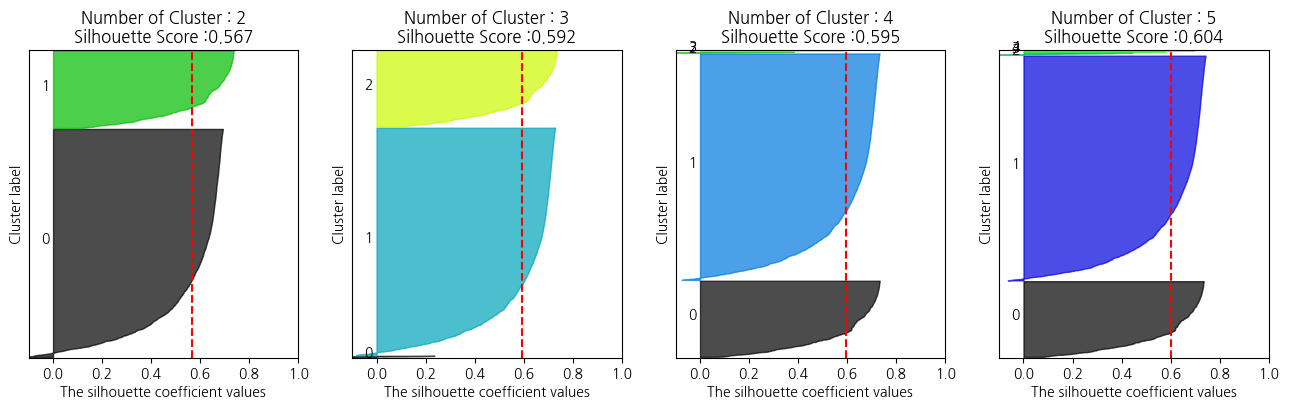

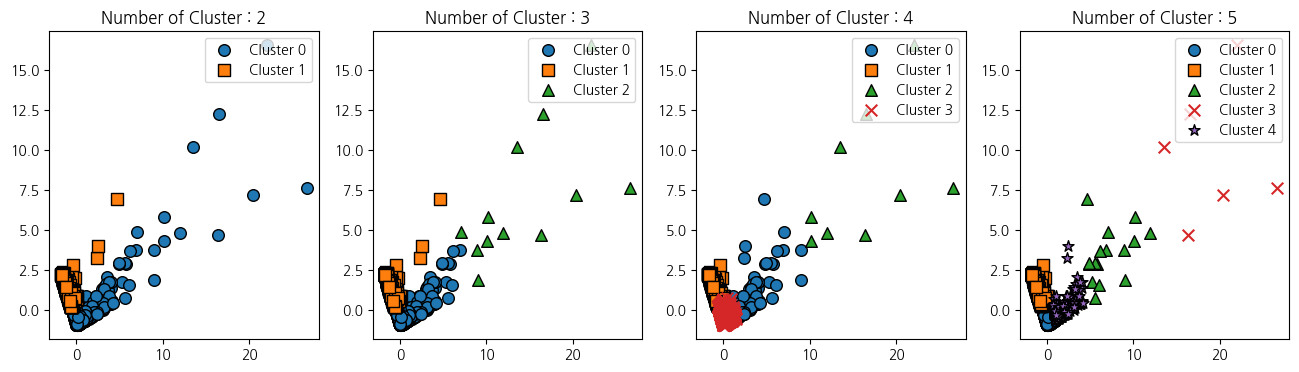

In [24]:
# 실루엣 계수 및 데이터 구성
visualize_silhouette([2, 3, 4, 5], X_features_scaled)
visualize_kmeans_plot_multi([2, 3, 4, 5], X_features_scaled)

* 도출된 결과를 분석해보면, 군집이 3개 이상일 때부터는 데이터 세트의 개수가 너무 작은 군집이 만들어진다.
* 군집 내부에서도 특정 데이터의 분포가 작거나, 데이터가 광범위하게 퍼져 있는것을 알 수 있다.
* 이를 해결하기위해 로그변환을 해준다.

In [25]:
# 2개보다 군집수를 늘린 3개, 4개, 5개에서는 군집 내 데이터 포인트 수가 너무 적은 군집 발생
# 이는 앞에서 살펴본 데이터 상의 왜곡 때문
# 따라서 데이터 분포 왜곡을 해소하기 위하여 로그화 진행

# Log변환을 통해 데이터 변환
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score, silhouette_samples

# Recency, Frequecny, Monetary 컬럼에 각각 로그 변환을 수행해준다
cust_df['Recency_log'] = np.log1p(cust_df['Recency'])
cust_df['Frequency_log'] = np.log1p(cust_df['Frequency'])
cust_df['Monetary_log'] = np.log1p(cust_df['Monetary'])

# Log화한 데이터에 StandardScaling 적용
# StandardScaler 객체에서 fit_transform() 메서드를 호출하여 스케일러를 데이터에 맞게 핏(fit)하고 스케일링 변환
X_features = cust_df[['Recency_log', 'Frequency_log', 'Monetary_log']].values
X_features_scaled = StandardScaler().fit_transform(X_features)

# 클러스터 3개인 KMeans 객체 생성
kmeans = KMeans(n_clusters = 3, random_state = 0)

# 학습 및 예측한 클러스터 라벨을 labels 객체에 저장
labels = kmeans.fit_predict(X_features_scaled)

# labels 객체의 내용을 cust_df의 cluster_label 컬럼에 저장
cust_df['cluster_label'] = labels

# 실루엣 스코어 출력
print('Silhouette Score: {0:.3f}'.format(silhouette_score(X_features_scaled, labels)))

Silhouette Score: 0.303


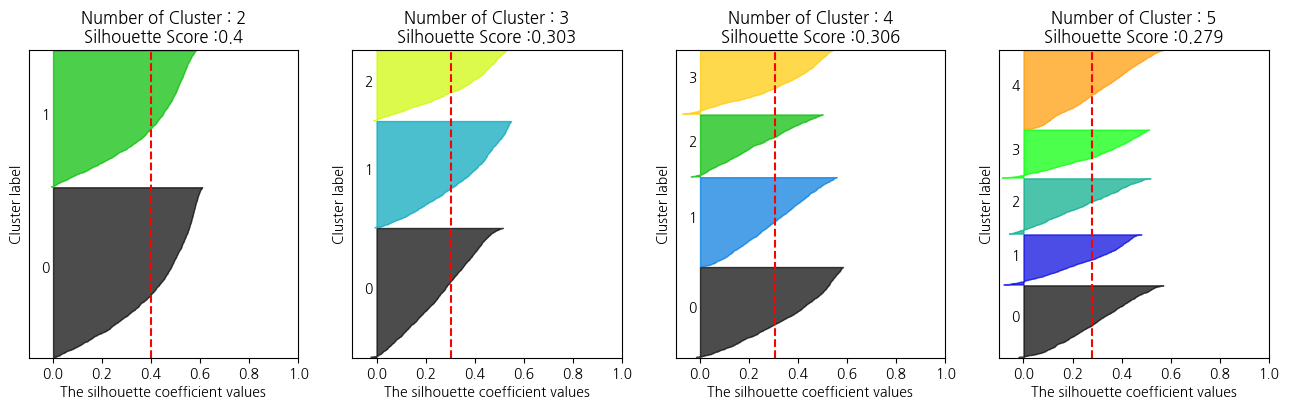

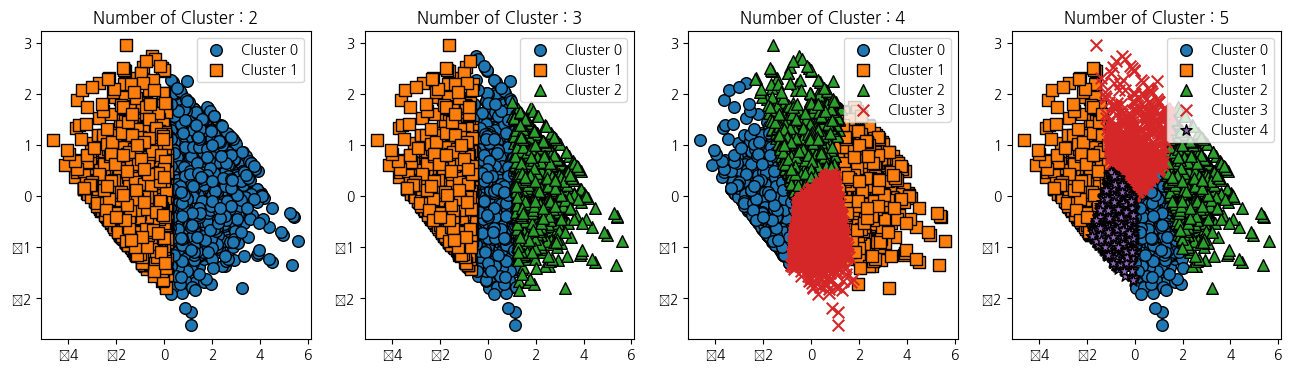

In [26]:
# 실루엣 계수 및 데이터 구성
visualize_silhouette([2, 3, 4, 5], X_features_scaled)
visualize_kmeans_plot_multi([2, 3, 4, 5], X_features_scaled)